## Finetuning BERT for Emotion Classification on an Emotionally Labelled Novel Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install ktrain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 71.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 67.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 653.6/653.6 kB 58.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 126.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 86.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 kB 53.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Prepar

In [3]:
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit
import numpy as np
import ktrain
import matplotlib.pyplot as plt

### Import, Split, and Encode Dataset

Import the Novel dataset, with labelled emotions

In [4]:
df_full = pd.read_csv('/content/drive/MyDrive/novel_sentences_emotionally_labelled.csv', encoding='utf-8')

In [5]:
df_full.sample(10)

,NovelId,SentenceId,Emotion,Text
3939,57,47,Surprise,"""That would be a fine thing!"" cried the miller..."
12289,147,16,Neutral,"""They will hang one, And roast another."""
14327,167,88,Neutral,When Mrs. Tittlemouse ventured to come out--ev...
6724,95,20,Anger,"All this was new and interesting; that is, for..."
9943,125,4,Neutral,"One of the slippers she could not find, and a ..."
3818,56,16,Neutral,"Then Heinel said, ""Father, give yourself very ..."
14071,165,8,Neutral,She set off on a fine spring afternoon along t...
7680,107,51,Disgust,"""'You are talking too much,' said the tinder-b..."
11430,137,51,Neutral,The wind could have told that his only protect...
7014,100,39,Happiness,"""With the crow? why, I am going to give it to ..."


In [6]:
len(df_full)

15302

Split dataset, maintaining novel sentences together, and maintaining the distribution of emotions across the splits

In [7]:
splitter = GroupShuffleSplit(n_splits=2, random_state=12345)
train_idx, test_idx = next(splitter.split(X=df_full, y=df_full["Emotion"], groups=df_full["NovelId"]))

In [8]:
len(train_idx), len(test_idx)

(11300, 4002)

In [9]:
df_train = df_full.iloc[train_idx]
df_test = df_full.iloc[test_idx]

In [10]:
df_train.head(10)

,NovelId,SentenceId,Emotion,Text
0,0,0,Neutral,In a certain mill lived an old miller who had ...
1,0,1,Neutral,"As they had been with him several years, he on..."
2,0,2,Disgust,"The third of the boys was, however, the drudge..."
3,0,3,Neutral,"Then all three went out together, and when the..."
4,0,4,Neutral,"Hans, however, went with them, and when it was..."
5,0,5,Neutral,The two sharp ones waited until Hans had falle...
6,0,6,Neutral,And they thought they had done a very clever t...
7,0,7,Neutral,"When the sun arose, and Hans woke up, he was l..."
8,0,8,Surprise,"He looked around on every side and exclaimed, ..."
9,0,9,Sadness,"Then he got up and clambered out of the cave, ..."


In [11]:
df_test.head(10)

,NovelId,SentenceId,Emotion,Text
113,2,0,Sadness,Little brother took his little sister by the h...
114,2,1,Sadness,Our meals are the hard crusts of bread that ar...
115,2,2,Sadness,May Heaven pity us.
116,2,3,Sadness,If our mother only knew!
117,2,4,Neutral,"Come, we will go forth together into the wide ..."
118,2,5,Sadness,"They walked the whole day over meadows, fields..."
119,2,6,Sadness,"In the evening they came to a large forest, an..."
120,2,7,Neutral,"The next day when they awoke, the sun was alre..."
121,2,8,Neutral,"Then the brother said, ""Sister, I am thirsty; ..."
122,2,9,Neutral,The brother got up and took the little sister ...


Confirmed the split happened across Novel IDs

In [12]:
df_train["NovelId"].unique()

array([  0,   1,   3,   4,   5,   6,   7,   8,   9,  11,  12,  13,  14,
        15,  18,  19,  20,  21,  22,  23,  25,  26,  27,  28,  29,  30,
        31,  32,  34,  36,  37,  38,  39,  41,  43,  44,  45,  46,  47,
        49,  50,  51,  52,  53,  54,  56,  57,  58,  59,  60,  61,  62,
        63,  64,  65,  66,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        79,  80,  81,  82,  83,  84,  85,  87,  88,  90,  91,  93,  94,
        96,  97,  98,  99, 101, 102, 103, 105, 106, 107, 108, 109, 110,
       112, 113, 114, 115, 116, 117, 118, 119, 123, 124, 125, 126, 127,
       129, 130, 131, 132, 133, 134, 135, 137, 138, 139, 142, 143, 144,
       145, 148, 149, 152, 153, 154, 155, 156, 157, 159, 160, 161, 163,
       164, 166, 167, 168, 169, 171, 172, 173, 174, 175])

In [13]:
df_test["NovelId"].unique()

array([  2,  10,  16,  17,  24,  33,  35,  40,  42,  48,  55,  67,  68,
        78,  86,  89,  92,  95, 100, 104, 111, 120, 121, 122, 128, 136,
       140, 141, 146, 147, 150, 151, 158, 162, 165, 170])

Confirmed distribution of Emotions across train and test splits are more or less similar

In [14]:
100*df_train["Emotion"].value_counts()/len(df_train)

Neutral      60.362832
Happiness    12.752212
Sadness       6.752212
Surprise      6.424779
Fear          5.371681
Anger         5.194690
Disgust       3.141593
Name: Emotion, dtype: float64

In [15]:
100*df_test["Emotion"].value_counts()/len(df_test)

Neutral      64.317841
Happiness    11.044478
Sadness       5.622189
Surprise      5.472264
Anger         5.347326
Fear          4.797601
Disgust       3.398301
Name: Emotion, dtype: float64

Extract X and y

In [16]:
X_train = df_train["Text"].tolist()
X_test = df_test["Text"].tolist()
y_train = df_train["Emotion"].tolist()
y_test = df_test["Emotion"].tolist()

In [17]:
class_names = df_full["Emotion"].unique().tolist()
class_names

['Neutral', 'Disgust', 'Surprise', 'Sadness', 'Happiness', 'Anger', 'Fear']

In [18]:
encoding = {cn: i for i, cn in enumerate(class_names)}

In [19]:
encoding

{'Neutral': 0,
 'Disgust': 1,
 'Surprise': 2,
 'Sadness': 3,
 'Happiness': 4,
 'Anger': 5,
 'Fear': 6}

In [20]:
y_train = [encoding[lbl] for lbl in y_train]
y_test = [encoding[lbl] for lbl in y_test]

In [21]:
y_train[:10]

[0, 0, 1, 0, 0, 0, 0, 0, 2, 3]

### Preprocessing Data for BERT

In [22]:
sent_len = [len(x.split()) for x in X_train]

(array([1.59292035e-02, 3.06594348e-02, 3.18798173e-02, 3.23080217e-02,
        3.10662289e-02, 2.66985441e-02, 1.98044533e-02, 1.80488153e-02,
        1.05338281e-02, 7.36511562e-03, 5.69511847e-03, 3.48986583e-03,
        2.65486726e-03, 1.75563802e-03, 1.39166429e-03, 8.13588353e-04,
        5.56665715e-04, 4.92435056e-04, 1.71281758e-04, 1.28461319e-04,
        1.71281758e-04, 8.56408792e-05, 8.56408792e-05, 0.00000000e+00,
        4.28204396e-05, 2.14102198e-05, 2.14102198e-05, 2.14102198e-05,
        0.00000000e+00, 4.28204396e-05]),
 array([  1.        ,   5.13333333,   9.26666667,  13.4       ,
         17.53333333,  21.66666667,  25.8       ,  29.93333333,
         34.06666667,  38.2       ,  42.33333333,  46.46666667,
         50.6       ,  54.73333333,  58.86666667,  63.        ,
         67.13333333,  71.26666667,  75.4       ,  79.53333333,
         83.66666667,  87.8       ,  91.93333333,  96.06666667,
        100.2       , 104.33333333, 108.46666667, 112.6       ,
      

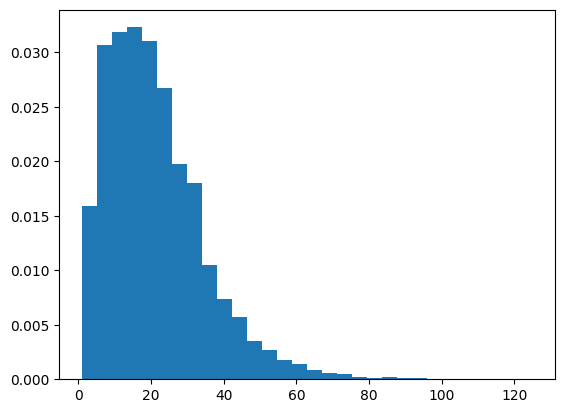

In [23]:
plt.hist(sent_len, density=True, bins=30)

In [24]:
sent_len.sort()
cutoff_val = 55
cutoff_idx = next(x[0] for x in enumerate(sent_len) if x[1] > cutoff_val)
perc_sent_fewer_words_cutoff_val = cutoff_idx/len(sent_len)
perc_sent_fewer_words_cutoff_val

0.9777876106194691

In [33]:
(X_train_pp,  y_train_pp), (X_test_pp, y_test_pp), preproc = ktrain.text.texts_from_array(x_train=X_train, y_train=y_train, x_test=X_test, y_test=y_test,
                                                                                          class_names=class_names, preprocess_mode='bert', maxlen=150,
                                                                                          max_features=35000)

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


task: text classification


### Training and Validations

In [34]:
model = ktrain.text.text_classifier('bert', train_data=(X_train_pp, y_train_pp), preproc=preproc)

Is Multi-Label? False
maxlen is 150


/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


done.


In [27]:
class_weights = dict(df_train["Emotion"].value_counts()/len(df_train))
class_weights = dict((encoding[key], value) for (key, value) in class_weights.items())

In [35]:
learner = ktrain.get_learner(model, train_data=(X_train_pp, y_train_pp), val_data=(X_test_pp, y_test_pp), batch_size=32) # default batch size = 32

In [ ]:
learner.lr_find(max_epochs=10) # simulates training to identify a good learning rate
learner.lr_plot()

simulating training for different learning rates... this may take a few moments...


ValueError: ignored

In [29]:
lr_opt = 9e-3

In [36]:
learner.fit_onecycle(2e-5, epochs=10, class_weight = class_weights)
# class_weight = class_weights)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/10
354/354 [==============================] - 469s 1s/step - loss: 0.1598 - accuracy: 0.6032 - val_loss: 1.3483 - val_accuracy: 0.6497
Epoch 2/10
354/354 [==============================] - 404s 1s/step - loss: 0.1193 - accuracy: 0.6329 - val_loss: 1.1781 - val_accuracy: 0.6819
Epoch 3/10
354/354 [==============================] - 404s 1s/step - loss: 0.0992 - accuracy: 0.6824 - val_loss: 1.0849 - val_accuracy: 0.7031
Epoch 4/10
354/354 [==============================] - 442s 1s/step - loss: 0.0778 - accuracy: 0.7386 - val_loss: 1.0912 - val_accuracy: 0.7134
Epoch 5/10
354/354 [==============================] - 434s 1s/step - loss: 0.0582 - accuracy: 0.7896 - val_loss: 1.2241 - val_accuracy: 0.7096
Epoch 6/10
354/354 [==============================] - 440s 1s/step - loss: 0.0417 - accuracy: 0.8364 - val_loss: 1.3140 - val_accuracy: 0.6884
Epoch 7/10
354/354 [==============================] - 442s 1s/step - loss: 0.02

In [ ]:
learner = ktrain.get_learner(model, train_data=(X_train_pp, y_train_pp), val_data=(X_test_pp, y_test_pp), batch_size=32) # default batch size = 32

In [ ]:
learner.freeze()

In [ ]:
learner.fit_onecycle(1e-5, epochs=3)

In [ ]:
learner = ktrain.get_learner(model, train_data=(X_train_pp, y_train_pp), val_data=(X_test_pp, y_test_pp), batch_size=32) # default batch size = 32

In [ ]:
learner.autofit(1e-5, epochs=3)

In [ ]:
learner = ktrain.get_learner(model, train_data=(X_train_pp, y_train_pp), val_data=(X_test_pp, y_test_pp), batch_size=32) # default batch size = 32

In [ ]:
learner.autofit(1e-3, epochs=3)

In [ ]:
learner.autofit(1e-3, epochs=3, class_weight = class_weights)

Highest LR with a decreasing loss seems to be 1e-2